<H1> <align='Center'> Melanoma Detection Assignment   </H1>
###########========================########### <br>
<b> Title           : </b> Melanoma Detection Assignment  <br>
<b> Author          : </b> Surendra D M | Soumyashree | Anuj <br>
<b> Start Date      : </b> 01/11/2023 <br>
<b> Completion Date : </b> 06/11/2023<br>
<b> Python Version  : </b> 3.11.1 <br>
###########========================########### <br>
File Path used is through mounting the google drive, ensure to follow the same approach when testing the code.


# **Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Importing all the important libraries

In [88]:
import pathlib
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img



import time
start = time.time()

In [70]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)

In [71]:
# Read the data from Google Drive

#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [89]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN-DataSet/Train/")
data_dir_test = pathlib.Path("CNN-DataSet/Test/")

In [90]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [91]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [92]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=(batch_size)

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [93]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=(batch_size)

)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [94]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

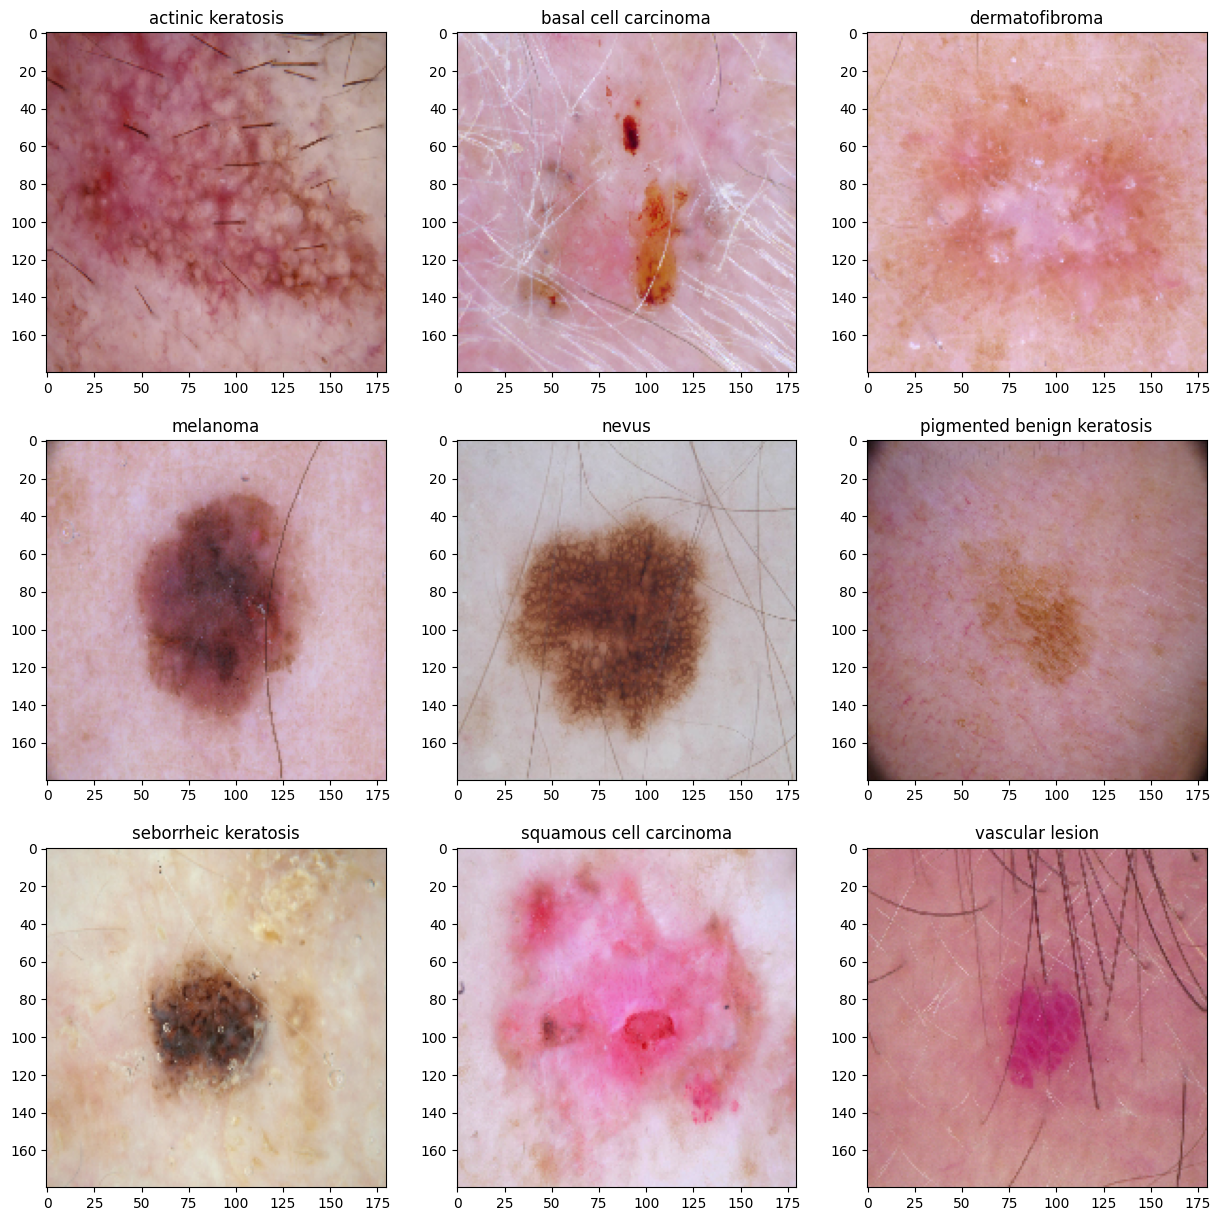

In [95]:
files_path = {}
for class_name in class_names:
    files_path[class_name] = list(map(lambda x:str(data_dir_train)+'/'+class_name+'/'+x,os.listdir(str(data_dir_train)+'/'+class_name)))


#Visualize image
plt.figure(figsize=(15,15))
index = 0
for class_name in class_names:
    path_list = files_path[class_name][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(class_name)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [96]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [97]:
Number_of_Classes = len(class_names)

CNN_Model = Sequential()

CNN_Model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
CNN_Model.add(layers.Conv2D(16,kernel_size=(3,3),padding='same',activation='relu'))
CNN_Model.add(layers.MaxPooling2D())

#Second Convulation Layer
CNN_Model.add(layers.Conv2D(32,3,padding='same',activation='relu'))
CNN_Model.add(layers.MaxPooling2D())



#Second Convulation Layer
CNN_Model.add(layers.Conv2D(64,3,padding='same',activation='relu'))
CNN_Model.add(layers.MaxPooling2D())
CNN_Model.add(layers.Dropout(0.25))
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
CNN_Model.add(layers.Flatten())

#Dense Layer
CNN_Model.add(layers.Dense(128,activation='relu'))


#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
CNN_Model.add(layers.Dense(Number_of_Classes))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [98]:
### Todo, choose an appropirate optimiser and loss function
CNN_Model.compile(optimizer="adam",
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
# View the summary of all layers
CNN_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [99]:
epochs = 20
history = CNN_Model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 18s 267ms/step - loss: 2.1871 - accuracy: 0.1931 - val_loss: 2.3221 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 14s 252ms/step - loss: 1.8353 - accuracy: 0.3650 - val_loss: 2.6462 - val_accuracy: 0.2609
Epoch 3/20
56/56 [==============================] - 14s 255ms/step - loss: 1.5068 - accuracy: 0.4905 - val_loss: 2.7470 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 14s 258ms/step - loss: 1.4094 - accuracy: 0.5167 - val_loss: 2.3054 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 15s 264ms/step - loss: 1.3231 - accuracy: 0.5452 - val_loss: 2.0935 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 15s 269ms/step - loss: 1.2582 - accuracy: 0.5625 - val_loss: 2.4475 - val_accuracy: 0.2174
Epoch 7/20
56/56 [==============================] - 15s 268ms/step - loss: 1.2436 - accuracy: 0.5558 - val_loss: 2.3104 - val_accuracy: 0.2609
Epoch 8/20

### Visualizing training results

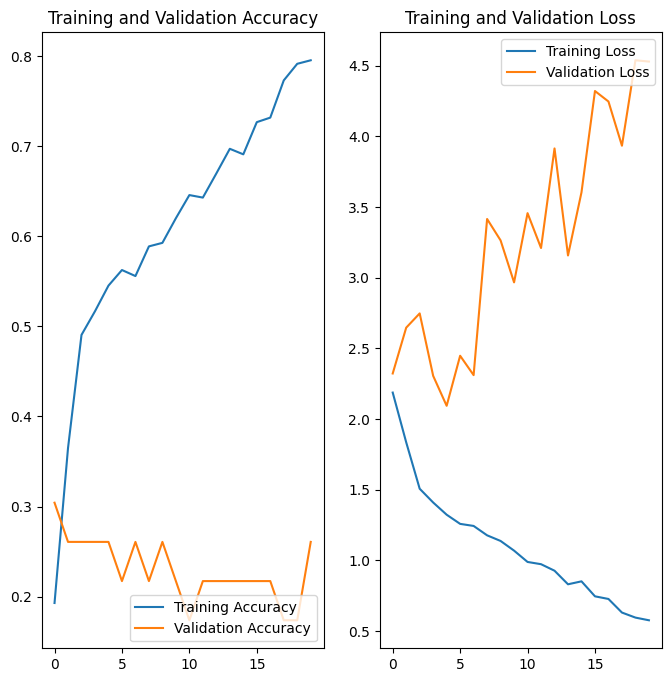

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit







1.   The model is clearly overfitting considering that the training accuracy is around 80% and above, however validation accuracy is very poor
2.   Data visualization shows clearly on how the accuracy varies between training and validation

In [101]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

#we have decided to use Rnadomflip, Random Rotation and Randomzoom to augment the data.

data_augment = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.1),
                             layers.experimental.preprocessing.RandomZoom(0.1)
])

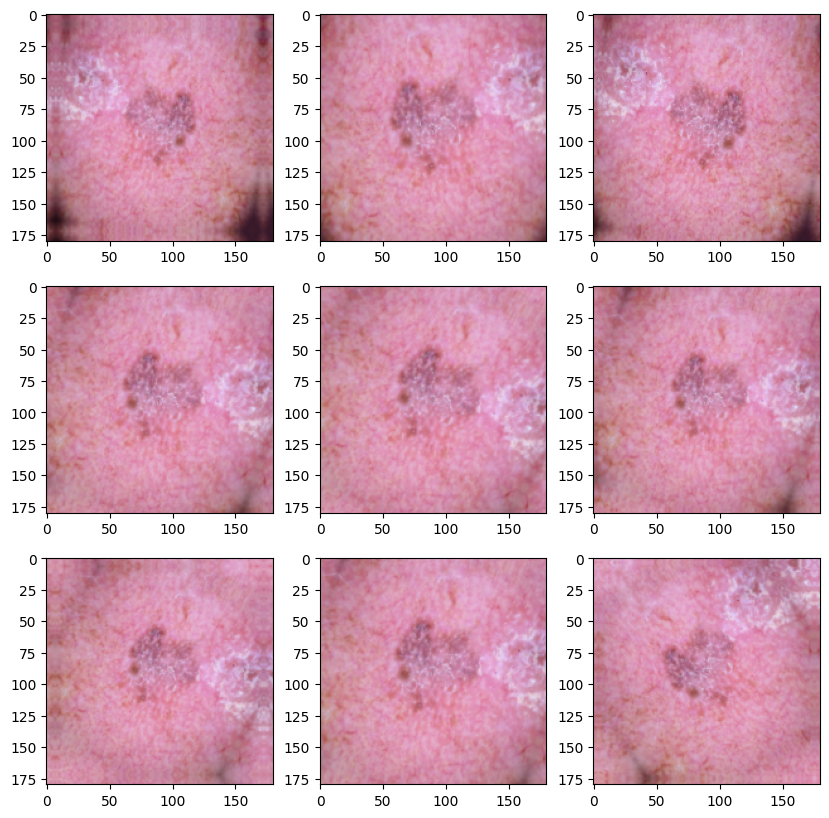

In [102]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

image, label = next(iter(train_ds))

image = np.array(image,np.int32)
plt.figure(figsize=(10,10))

for i in range(9):
  augmented_image = data_augment(image)
  ax = plt.subplot(3, 3, i + 1)
  augumented_image1 = np.array(augmented_image[0],np.int32)
  plt.imshow(augumented_image1)

### Todo:
### Create the model, compile and train the model


In [103]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
CNN_Model2 = Sequential()
CNN_Model2.add(data_augment)
CNN_Model2.add(layers.experimental.preprocessing.Rescaling(1./255))   #Rescaling Layer

#First Convulation layer
CNN_Model2.add(layers.Conv2D(16,3,padding='same',activation='relu'))
CNN_Model2.add(layers.MaxPool2D())

#Second Convulation Layer
CNN_Model2.add(layers.Conv2D(32,3,padding='same',activation='relu'))
CNN_Model2.add(layers.MaxPool2D())



#Second Convulation Layer
CNN_Model2.add(layers.Conv2D(64,3,padding='same',activation='relu'))
CNN_Model2.add(layers.MaxPool2D())
CNN_Model.add(layers.Dropout(0.5))
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
CNN_Model2.add(layers.Flatten())

#Dense Layer
CNN_Model2.add(layers.Dense(128,activation='relu'))


#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
CNN_Model2.add(layers.Dense(Number_of_Classes))

CNN_Model2.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

### Compiling the model

In [104]:
## Your code goes here

CNN_Model2.compile(optimizer="adam",
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

### Training the model

In [105]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = CNN_Model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 17s 277ms/step - loss: 1.8787 - accuracy: 0.3025 - val_loss: 2.3148 - val_accuracy: 0.2174
Epoch 2/20
56/56 [==============================] - 16s 277ms/step - loss: 1.5767 - accuracy: 0.4347 - val_loss: 2.5017 - val_accuracy: 0.3478
Epoch 3/20
56/56 [==============================] - 16s 278ms/step - loss: 1.4627 - accuracy: 0.4671 - val_loss: 2.5786 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 16s 284ms/step - loss: 1.4089 - accuracy: 0.4961 - val_loss: 2.4508 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 16s 285ms/step - loss: 1.3549 - accuracy: 0.5145 - val_loss: 2.4778 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 16s 281ms/step - loss: 1.2941 - accuracy: 0.5352 - val_loss: 2.5671 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 15s 276ms/step - loss: 1.2617 - accuracy: 0.5458 - val_loss: 2.4538 - val_accuracy: 0.2609
Epoch 8/20

### Visualizing the results

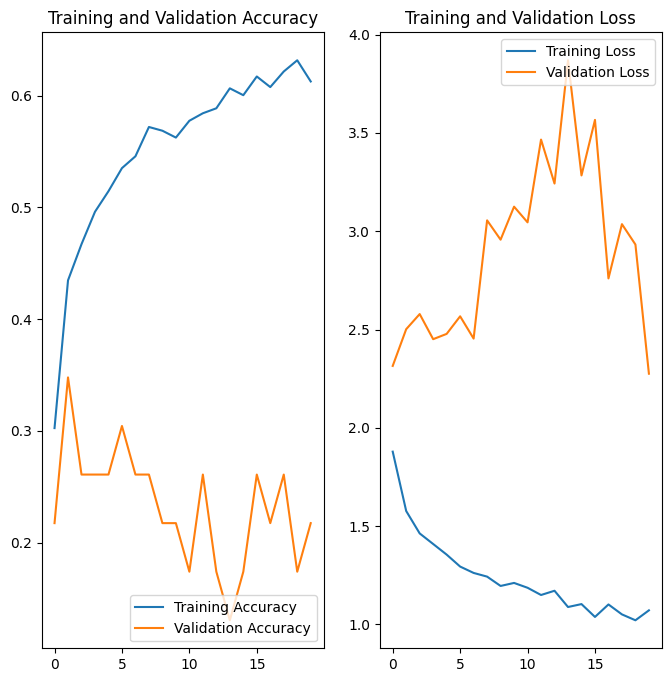

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

there is very little improvement in terms of how the model is behavving in validation accuracy perhaps more finetuning is required. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

                        Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139


<Axes: xlabel='Class', ylabel='No. of Image'>

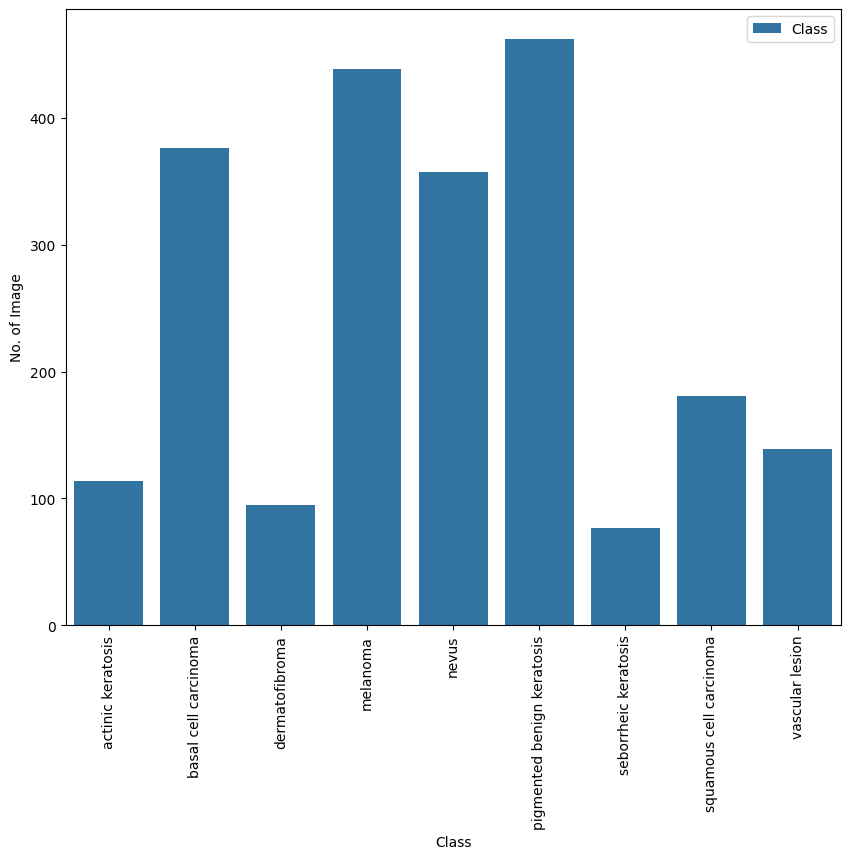

In [108]:
## Your code goes here.

def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
print(df)
plt.figure(figsize=(10, 8))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="No. of Image", data=df,
            label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis - has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis  = dominates the data in terms of proportion


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [109]:
!pip install Augmentor


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [110]:
str(data_dir_train)

'CNN-DataSet\\Train'

In [111]:
path_to_training_dataset=str(data_dir_train) + "/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN-DataSet\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DE50EE84D0>: 100%|██████████| 500/500 [00:01<00:00, 265.53 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to CNN-DataSet\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DE4E120B50>: 100%|██████████| 500/500 [00:01<00:00, 270.02 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to CNN-DataSet\Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1DE50FC2990>: 100%|██████████| 500/500 [00:01<00:00, 263.92 Samples/s]


Initialised with 438 image(s) found.
Output directory set to CNN-DataSet\Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1DE3D3829D0>: 100%|██████████| 500/500 [00:07<00:00, 62.83 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to CNN-DataSet\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x1DE83F05D90>: 100%|██████████| 500/500 [00:08<00:00, 59.57 Samples/s]                     


Initialised with 462 image(s) found.
Output directory set to CNN-DataSet\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DE50FC1DD0>: 100%|██████████| 500/500 [00:02<00:00, 244.25 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to CNN-DataSet\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1DE4E7ECCD0>: 100%|██████████| 500/500 [00:03<00:00, 132.97 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to CNN-DataSet\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DE50F90050>: 100%|██████████| 500/500 [00:02<00:00, 248.01 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to CNN-DataSet\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DE50F45610>: 100%|██████████| 500/500 [00:01<00:00, 272.63 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [112]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [113]:

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['CNN-DataSet\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_03ac275f-34b6-4da3-98f0-0f88cc2b9fd8.jpg',
 'CNN-DataSet\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1fb53119-a3e5-4b62-992f-acc925644b32.jpg',
 'CNN-DataSet\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_36f1902b-da09-4886-87ca-085e73402e9a.jpg',
 'CNN-DataSet\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6ae8b941-04fe-416c-aece-d07a88745df9.jpg',
 'CNN-DataSet\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_d791a88c-6041-410f-8ae9-e1efc52cd92e.jpg',
 'CNN-DataSet\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_39d8f1e5-28ca-428b-b5a4-60b8969b04ee.jpg',
 'CNN-DataSet\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_b11cb6bb-05d8-44b3-9eb3-9b6574b6cc67.jpg',
 'CNN-DataSet\\Train\\actinic keratosis\\output\

In [114]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [115]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [116]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = df.append(df2)
new_df = df._append(df2,ignore_index=True)

In [117]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [119]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [120]:
data_dir_test

WindowsPath('CNN-DataSet/Test')

In [121]:
data_dir_train= pathlib.Path('CNN-DataSet/Train/')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [122]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [124]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
CNN_Model3 = Sequential()

CNN_Model3.add(layers.experimental.preprocessing.Rescaling((1./255),input_shape=(img_height, img_width, 3)))   #Rescaling Layer

#First Convulation layer
CNN_Model3.add(layers.Conv2D(16,3,padding='same',activation='relu'))
CNN_Model3.add(layers.MaxPool2D())

#Second Convulation Layer
CNN_Model3.add(layers.Conv2D(32,3,padding='same',activation='relu'))
CNN_Model3.add(layers.MaxPool2D())



#third Convulation Layer
CNN_Model3.add(layers.Conv2D(64,3,padding='same',activation='relu'))
CNN_Model3.add(layers.MaxPool2D())
CNN_Model3.add(layers.Dropout(0.5))
#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
CNN_Model3.add(layers.Flatten())

#Dense Layer
CNN_Model3.add(layers.Dense(128,activation='relu'))


#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
CNN_Model3.add(layers.Dense(Number_of_Classes))

CNN_Model3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 45, 45, 64)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [125]:
## your code goes here
CNN_Model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [126]:
epochs = 30
history = CNN_Model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


169/169 [==============================] - 55s 319ms/step - loss: 1.9526 - accuracy: 0.2567 - val_loss: 1.5742 - val_accuracy: 0.3972
Epoch 2/30
169/169 [==============================] - 52s 308ms/step - loss: 1.4497 - accuracy: 0.4505 - val_loss: 1.3819 - val_accuracy: 0.4736
Epoch 3/30
169/169 [==============================] - 50s 297ms/step - loss: 1.2592 - accuracy: 0.5247 - val_loss: 1.1818 - val_accuracy: 0.5419
Epoch 4/30
169/169 [==============================] - 50s 294ms/step - loss: 1.1178 - accuracy: 0.5831 - val_loss: 1.0940 - val_accuracy: 0.5976
Epoch 5/30
169/169 [==============================] - 50s 294ms/step - loss: 0.9897 - accuracy: 0.6302 - val_loss: 1.0265 - val_accuracy: 0.6132
Epoch 6/30
169/169 [==============================] - 50s 296ms/step - loss: 0.8917 - accuracy: 0.6695 - val_loss: 1.0030 - val_accuracy: 0.6385
Epoch 7/30
169/169 [==============================] - 50s 297ms/step - loss: 0.7780 - accuracy: 0.7168 - val_loss: 0.8698 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

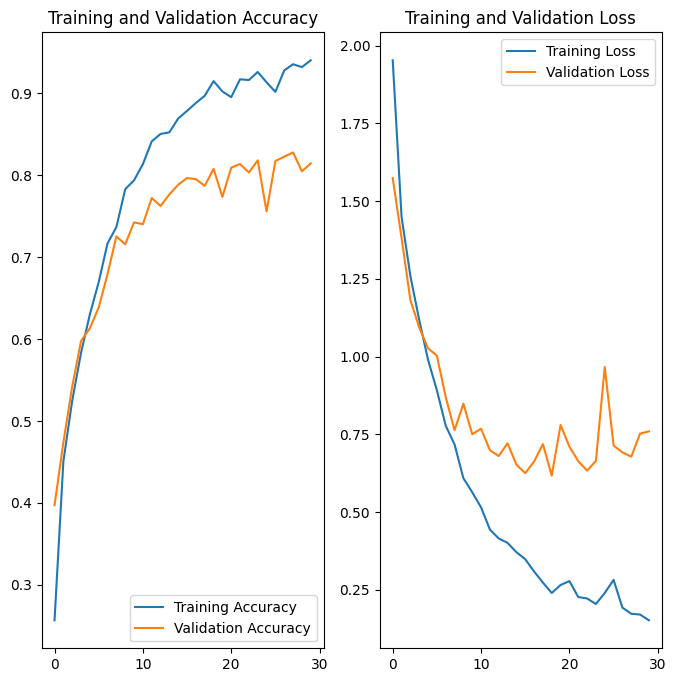

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes, the augmentor module really helped fine tune the model and get rid of Overfitting in our case.
we are getting a good validatiion accuracry ~80%+ and 90%+ Training Accuracy. we can go with this model.